In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


# Pytorch device specific configuration
# Pytorch Gpu Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [2]:
# import dataset
import pandas as pd

iris = pd.read_csv(
    "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv"
)

# convert from pandas dataframe to tensor
data = torch.tensor(iris[iris.columns[0:4]].values).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa'] = 0 # don't need!
labels[iris.species == "versicolor"] = 1
labels[iris.species == "virginica"] = 2

In [3]:
# Batch Size
batch_size = 16
# Use scikit learn train_test_split to split the data
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2
)

# Convert data into pytorch dataset
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Translate train and test data to dataloder objects
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    generator=torch.Generator(device=device),
)
test_loader = DataLoader(
    test_data,
    batch_size=test_data.tensors[0].shape[0],
    generator=torch.Generator(device=device),
)

In [6]:
# Create the model class
class ANNModelClass(nn.Module):
    def __init__(self, dr):
        super().__init__()

        # Layers
        self.input = nn.Linear(4, 128)
        self.hidden1 = nn.Linear(128, 256)
        self.hidden2 = nn.Linear(256, 128)
        self.hidden3 = nn.Linear(128, 128)
        self.hidden4 = nn.Linear(128, 128)
        self.hidden5 = nn.Linear(128, 128)
        self.hidden6 = nn.Linear(128, 128)
        self.output = nn.Linear(128, 3)

        # Parameters
        self.dr = dr

    # forward pass
    def forward(self, x):

        # input Layer
        x = F.relu(self.input(x))
        x = F.dropout(
            x, p=self.dr, training=self.training
        )  # self.training turns off dropout in testing mode

        # Hidden Layer 1
        x = F.relu(self.hidden1(x))
        x = F.dropout(x, p=self.dr, training=self.training)
        # Hidden Layer 2
        x = F.relu(self.hidden2(x))
        x = F.dropout(x, p=self.dr, training=self.training)
        # Hidden Layer 3
        x = F.relu(self.hidden3(x))
        x = F.dropout(x, p=self.dr, training=self.training)
        # Hidden Layer 4
        x = F.relu(self.hidden4(x))
        x = F.dropout(x, p=self.dr, training=self.training)
        # Hidden Layer 5
        x = F.relu(self.hidden5(x))
        x = F.dropout(x, p=self.dr, training=self.training)

        # Hidden Layer 6
        x = F.relu(self.hidden6(x))
        x = F.dropout(x, p=self.dr, training=self.training)

        # Output Layer
        x = self.output(x)

        return x

In [7]:
# Test model class
tmpNet = ANNModelClass(0.25)

# Run model on random data
tmpData = torch.randn((50, 4))
yHat = tmpNet(tmpData)  # Let's check for typos in the model code
print(yHat)

tensor([[ 0.0864, -0.0502, -0.1066],
        [ 0.0832, -0.0441, -0.0991],
        [ 0.1027, -0.0327, -0.0641],
        [ 0.1072, -0.0263, -0.0436],
        [ 0.0968, -0.0402, -0.0791],
        [ 0.0672, -0.0541, -0.0693],
        [ 0.0990, -0.0228, -0.0446],
        [ 0.1073, -0.0325, -0.0952],
        [ 0.0900, -0.0222, -0.0222],
        [ 0.0922,  0.0097, -0.0803],
        [ 0.1029, -0.0440, -0.0753],
        [ 0.0752, -0.0291, -0.0883],
        [ 0.0991, -0.0385, -0.0933],
        [ 0.1029, -0.0436, -0.0547],
        [ 0.0855, -0.0141, -0.0748],
        [ 0.1202, -0.0538, -0.0614],
        [ 0.0999, -0.0079, -0.0613],
        [ 0.1037, -0.0139, -0.0794],
        [ 0.1073, -0.0152, -0.0575],
        [ 0.0831, -0.0063, -0.0825],
        [ 0.1187, -0.0169, -0.0710],
        [ 0.0550, -0.0385, -0.0650],
        [ 0.0960, -0.0193, -0.0797],
        [ 0.1163, -0.0306, -0.0668],
        [ 0.0780, -0.0300, -0.0860],
        [ 0.1016, -0.0088, -0.0639],
        [ 0.1011, -0.0372, -0.0453],
 

In [8]:
# Function to create a model
def createNewModel(dr, lr=0.005):
    # Class instance
    ANNIris = ANNModelClass(dr)

    # Loss Function
    lossFun = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.SGD(ANNIris.parameters(), lr=lr)

    return ANNIris, lossFun, optimizer

In [9]:
# Function to train the model
def trainTheModel(ANNIris, optimizer, lossFun, train_loader, test_loader, nEpochs):

    # Initialize accuricies
    trainAcc = []
    testAcc = []

    # The Loop
    for epoch in range(nEpochs):
        ANNIris.train()  # Training mode

        # Batch accuracy
        batchAcc = []
        for X, y in train_loader:
            # Forward pass
            yHat = ANNIris(X)
            loss = lossFun(yHat, y)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute Batch accuracy
            batchAcc.append(
                100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()).item()
            )

        # Train accuracy
        trainAcc.append(np.mean(batchAcc))

        # Test Accuracy
        ANNIris.eval()  # Put model into evalution mode
        X, y = next(iter(test_loader))
        predictables = torch.argmax(ANNIris(X), axis=1)
        testAcc.append(100 * torch.mean((predictables == y).float()).item())

    return trainAcc, testAcc

In [10]:
# Create a model
dr = 0.0
nEpochs = 500
ANNIris, lossFun, optimizer = createNewModel(dr, lr=0.005)

trainAcc, testAcc = trainTheModel(
    ANNIris, optimizer, lossFun, train_loader, test_loader, nEpochs
)

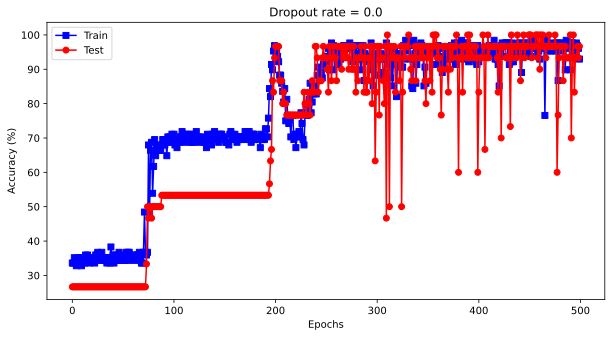

In [11]:
# Plot the results
fig = plt.figure(figsize=(10, 5))

plt.plot(trainAcc, "bs-")
plt.plot(testAcc, "ro-")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend(["Train", "Test"])
plt.title(f"Dropout rate = {dr}")
plt.show()

In [12]:
# Dropout rate experiment
drs = np.arange(10) / 10
results = np.zeros((len(drs), 2))

for i in range(len(drs)):

    # Create and train the model
    ANNIris, lossFun, optimizer = createNewModel(dr, lr=0.005)
    trainAcc, testAcc = trainTheModel(
        ANNIris, optimizer, lossFun, train_loader, test_loader, nEpochs
    )
    # Capture train and test accuracies

    results[i, 0] = np.mean(trainAcc[-50:])
    results[i, 1] = np.mean(testAcc[-50:])

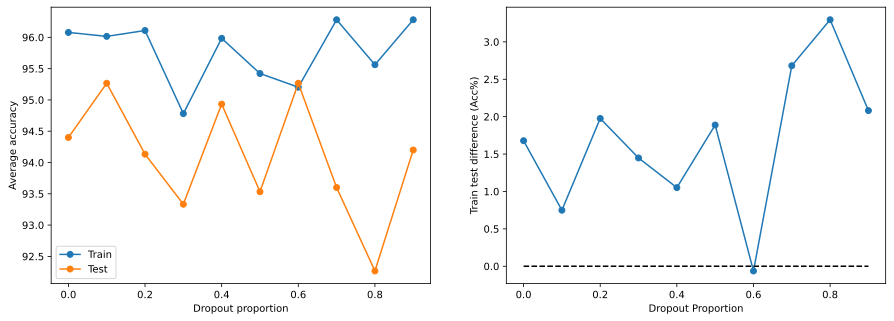

In [13]:
# Plot the experiment results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Axis 1
ax[0].plot(drs, results, "o-")
ax[0].set_xlabel("Dropout proportion")
ax[0].set_ylabel("Average accuracy")
ax[0].legend(["Train", "Test"])

ax[1].plot(drs, -np.diff(results, axis=1), "o-")
ax[1].plot([0, 0.9], [0, 0], "k--")
ax[1].set_xlabel("Dropout Proportion")
ax[1].set_ylabel("Train test difference (Acc%)")

plt.show()

In [ ]:
# Experiments
## 1.) Remove relu non linearity from the model # This basically brakes the model
## 2.) Dropout does not nacessarily improve for sallow models so let's make the model deep # That's only true if you have a lot of data